<a href="https://colab.research.google.com/github/harddy-bit/Cat-Dog-Classification-Using-Transfer-Learning-VGG16/blob/main/Transfer_Learning_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning VGG 16 using Keras

Please download the dataset from the below url

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 
    

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
!nvidia-smi

Tue Feb  2 16:12:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    28W /  70W |    227MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [6]:
tf.__version__

'2.4.1'

In [7]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob


In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/gdrive/MyDrive/kaggle_dataset/dogs-cats-dataset/dataset/training_set'
valid_path = '/content/gdrive/MyDrive/kaggle_dataset/dogs-cats-dataset/dataset/test_set'


In [9]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


58892288/58889256 [==============================] - 1s 0us/step


In [10]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [12]:
  # useful for getting number of output classes
folders = glob('/content/gdrive/MyDrive/kaggle_dataset/dogs-cats-dataset/dataset/training_set/*')

In [13]:
folders
# Two classes - Cats & Dogs

['/content/gdrive/MyDrive/kaggle_dataset/dogs-cats-dataset/dataset/training_set/cats',
 '/content/gdrive/MyDrive/kaggle_dataset/dogs-cats-dataset/dataset/training_set/dogs']

In [14]:
# our layers - you can add more if you want
x = Flatten()(vgg16.output)

In [15]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object -- combine the input of vgg16 and output dense layer as prediction
model = Model(inputs=vgg16.input, outputs=prediction)

In [16]:
# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [19]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/kaggle_dataset/dogs-cats-dataset/dataset/training_set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 8000 images belonging to 2 classes.


In [20]:
test_set = test_datagen.flow_from_directory('/content/gdrive/MyDrive/kaggle_dataset/dogs-cats-dataset/dataset/test_set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2000 images belonging to 2 classes.


In [21]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
250/250 [==============================] - 4388s 18s/step - loss: 0.4757 - accuracy: 0.8011 - val_loss: 0.1968 - val_accuracy: 0.9200
Epoch 2/50
250/250 [==============================] - 116s 465ms/step - loss: 0.2248 - accuracy: 0.9068 - val_loss: 0.2066 - val_accuracy: 0.9205
Epoch 3/50
250/250 [==============================] - 115s 462ms/step - loss: 0.1715 - accuracy: 0.9330 - val_loss: 0.2763 - val_accuracy: 0.9005
Epoch 4/50
250/250 [==============================] - 115s 461ms/step - loss: 0.1622 - accuracy: 0.9358 - val_loss: 0.2524 - val_accuracy: 0.9080
Epoch 5/50
250/250 [==============================] - 116s 462ms/step - loss: 0.1444 - accuracy: 0.9425 - val_loss: 0.2109 - val_accuracy: 0.9285
Epoch 6/50
250/250 [==============================] - 115s 461ms/step - loss: 0.1345 - accuracy: 0.9473 - val_loss: 0.2686 - val_accuracy: 0.9090
Epoch 7/50
250/250 [==============================] - 115s 460ms/step - loss: 0.1417 - accuracy: 0.9465 - val_loss: 0.3279 - 

In [22]:
from tensorflow.keras.models import load_model

model.save('/content/gdrive/MyDrive/Colab Notebooks/Cat Dog Classification Using VGG16/model_vgg16_catdog.h5')

In [23]:

from tensorflow.keras.models import load_model
 
# load model
model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Cat Dog Classification Using VGG16/model_vgg16_catdog.h5')

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

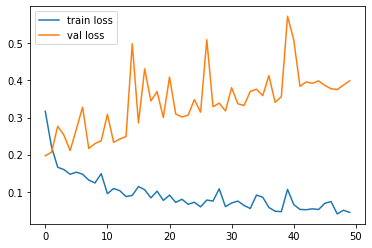

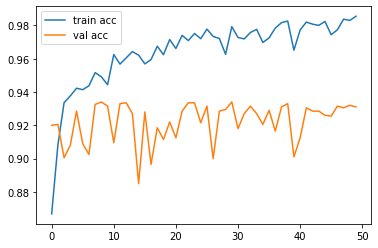

<Figure size 432x288 with 0 Axes>

In [33]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/Cat Dog Classification Using VGG16/LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/Cat Dog Classification Using VGG16/AccVal_acc')

In [26]:
y_pred = model.predict(test_set)


In [27]:
y_pred

array([[9.9999905e-01, 9.8903774e-07],
       [3.0539419e-13, 1.0000000e+00],
       [9.9986231e-01, 1.3771805e-04],
       ...,
       [1.0000000e+00, 1.3695049e-15],
       [9.9999976e-01, 2.7630537e-07],
       [2.8156709e-18, 1.0000000e+00]], dtype=float32)

In [28]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [29]:
y_pred

array([0, 1, 0, ..., 0, 0, 1])

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [31]:
#model=load_model('model_resnet50.h5')

In [32]:
img_data

NameError: ignored

In [39]:
img=image.load_img('/content/gdrive/MyDrive/kaggle_dataset/dogs-cats-dataset/dataset/test_set/cats/cat.4003.jpg',target_size=(224,224))



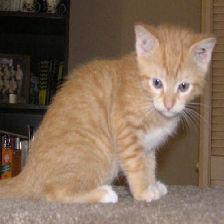

In [40]:
img

In [41]:
test_image = image.img_to_array(x)
test_image = test_image/255
test_image = np.expand_dims(test_image,axis=0)
result = model.predict(test_image)

In [42]:
result

array([[0.6670262 , 0.33297378]], dtype=float32)

In [44]:
a=np.argmax(model.predict(test_image), axis=1)

In [45]:
if a==0:
  print("The image classified is Cat")
else:
  print("The image classified is Dog")

The image classified is Cat
